In [1]:
from pathlib import Path
import gzip
import pickle

%matplotlib inline

In [2]:
#export
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from functools import partial
import math
import matplotlib.pyplot as plt

In [ ]:
# MNIST_url = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [3]:
home_path = Path('.').resolve()
data_path = home_path/"data"
file_name = data_path/'mnist.pkl.gz'
file_name

PosixPath('/Users/xianli/Desktop/fast/Part2/data/mnist.pkl.gz')

In [4]:
with gzip.open(file_name,'r') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

# Prepare dataloader

In [5]:
#export
class myDataset():
    def __init__(self,x,y):
        self.x, self.y = x, y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,i):
        return self.x[i], self.y[i]

In [6]:
bs = 64
ds_train = myDataset(x_train, y_train)
ds_valid = myDataset(x_valid, y_valid)


In [15]:
#export
def get_dls(ds_train, ds_valid, bs, **kwargs):
    return DataLoader(ds_train, bs, shuffle=True, **kwargs), DataLoader(ds_valid, bs, shuffle=False, **kwargs)

In [8]:
dl_train, dl_valid = get_dls(ds_train, ds_valid, bs)
len(dl_train), len(dl_valid) # len(dataloader) returns number of batches

(782, 157)

### refactor all the data into a databunch

Factor out the connected pieces of info out of the fit() argument list

`fit(epochs, model, loss_func, opt, train_dl, valid_dl)`

Let's replace it with something that looks like this:

`fit(1, learn)`

This will allow us to tweak what's happening inside the training loop in other places of the code because the `Learner` object will be mutable, so changing any of its attribute elsewhere will be seen in our training loop.

In [9]:
#export
class DataBunch():
    def __init__(self, dl_train,dl_valid, c=None):
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.c=c # number of output classes
    
    @property # make an alias for train_ds
    def train_ds(self):
        return self.dl_train.dataset
    @property
    def valid_ds(self):
        return self.dl_valid.dataset


In [10]:
data_bun = DataBunch(*get_dls(ds_train, ds_valid, bs), 10)
data_bun.train_ds.x.shape[0]

50000

In [11]:
fan_in, nh, fan_out = 784, 50, 10
lr = 0.01
def get_model():
    model = nn.Sequential(nn.Linear(fan_in,nh),nn.ReLU(),nn.Linear(nh,fan_out))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt


In [13]:
#export
def accuracy(pred, targ):
    return (torch.argmax(pred, dim = 1)==targ).float().mean()

In [14]:
class Learner():
    def __init__(self, model, opt,loss_func, data):
        self.model = model
        self.loss_func = loss_func
        self.opt = opt
        self.data=data

### input all elements and fit

In [16]:
data = DataBunch(*get_dls(ds_train, ds_valid, bs), c = 10) # package all the data
loss_func = F.cross_entropy
metric = accuracy
learner = Learner(*get_model(),loss_func, data)

In [17]:
def fit(epochs, learner):
    for ep in range(epochs):
        learner.model.train()
        for xb, yb in learner.data.dl_train:
            pred = learner.model(xb)
            loss = learner.loss_func(pred, yb)
            loss.backward()
            learner.opt.step()
            learner.opt.zero_grad()
        
        learner.model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in learner.data.dl_valid:
                pred = learner.model(xb)
                loss = learner.loss_func(pred, yb)
                tot_loss += loss
                if learner.metric is not None:
                    acc = learner.metric(pred, yb)
                    tot_acc += acc
            avg_loss = tot_loss/len(learner.data.dl_valid)
            if learner.metric is not None:
                avg_acc = tot_acc/len(learner.data.dl_valid)
        print(f'Epoch #{ep+1}, loss = {avg_loss}, accuracy = {avg_acc}')
    return avg_loss, avg_acc

In [18]:
fit(5,learner)

Epoch #1, loss = 0.6921629309654236, accuracy = 0.8561902642250061
Epoch #2, loss = 0.4329378306865692, accuracy = 0.8930135369300842
Epoch #3, loss = 0.36303117871284485, accuracy = 0.9012739062309265
Epoch #4, loss = 0.33092430233955383, accuracy = 0.9106289744377136
Epoch #5, loss = 0.31107544898986816, accuracy = 0.9127189517021179


(tensor(0.3111), tensor(0.9127))

# Callback version from beginning

In [19]:
#export
# camel case styple to snake case style naming, to be checked later
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [7]:
a, b = 1, 'bbb'
print(a and b)

a, b = 0, 'bbb'
print(a and b)

a, b = 'aa', None
print(a and b)

bbb
0
None


### base callback class
- does no real things
- fetch names from children
- set runner

In [21]:
#export
class Callback():
    _order = 0 # used later to set order of the callback calls
    def set_runner(self, runner):
        self.runner = runner
    
    def __getattr__(self, key): # fetch the requested parameter from runner
        return getattr(self.runner, key) # most hardwork is here
    
    @property
    def name(self):
        name = re.sub(r'Callback$','', self.__class__.__name__)
        return camel2snake(name or 'callback')

This first callback is reponsible to switch the model back and forth in training or validation mode, as well as maintaining a count of the iterations, or the percentage of iterations elapsed in the epoch.

In [22]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.runner.epochs_elp = 0. # number of epochs elapsed during training
        self.runner.batch_elp = 0. # number of batches elapsed
        # default return None
    
    def begin_epoch(self):
        self.runner.epochs_elp = self.ep # will be provided in training loop
        self.model.train() # set by runner property
        self.runner.in_train = True
    
    def after_batch(self):
        if not self.in_train: return 
        self.runner.epochs_elp += 1./self.num_batch # this will be run num_batch times during training/valid phases
        self.runner.batch_elp += 1
    
    def begin_validation(self):
        self.model.eval() # set by runner property
        self.runner.in_train = False
        

In [23]:
TrainEvalCallback().name

'train_eval'

In [24]:
# export
# helper function: standardize everything into lists
from typing import Iterable

def listify(inp):
    if inp is None: return []
    if isinstance(inp, list): return inp
    if isinstance(inp, Iterable): return list(inp)
    return [inp] 

Runner class

In [25]:
#export
class Runner(): # take callbacks and run the training
    def __init__(self, cbs=None, cb_funcs=None):
        # gather all callbacks
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb) # name done by base callback class
            cbs.append(cb)
        self.cbs = [TrainEvalCallback()] + cbs # always need the traineval callback
        # set flag
        self.stop = False
    
    def __call__(self, cb_name):
        # search through all callbacks in given order
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None) # return None if not found
            if f and f(): # if callback name not found, continue the process (by returning false)
                return True # a normally-exited f() will return False, so if it returns true, process will stop here
        return False # False == continue running == don't stop
    
    @property
    def model(self):
        return self.learn.model
    @property
    def opt(self):
        return self.learn.opt
    @property
    def loss_func(self):
        return self.learn.loss_func
    @property
    def data(self):
        return self.learn.data
    
    def one_batch(self,xb,yb):
        self.xb, self.yb = xb, yb
        if self('begin_batch'): return
        self.pred = self.model(xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred,yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()
    
    def all_batches(self, dl):
        self.num_batch = len(dl)
        for xb, yb in dl:
            if self.stop: break
            self.one_batch(xb,yb)
            self('after_batch')
        self.stop = False
    
    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
        try:
            for cb in self.cbs: cb.set_runner(self) # each callback is a sub-class of Callback
            
            if self('begin_fit'): return
            for ep in range(epochs):
                self.ep = ep
                if not self('begin_epoch'):
                    self.all_batches(self.data.dl_train)
                
                with torch.no_grad():
                    if not self('begin_validation'):
                        self.all_batches(self.data.dl_valid)
                if self('after_epoch'):break
        finally:
            self('after_fit')
            self.learn= None
            
        
        

metrics callbacks

In [26]:
#export
class AvgStats():
    def __init__(self,metrics,in_train):
        self.metrics = listify(metrics)
        self.in_train = in_train
    def reset(self):
        self.tot_loss = 0.
        self.count = 0
        self.tot_mets = [0.] * len(self.metrics)
    @property
    def all_stats(self):
        return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self):
        return [st/self.count for st in self.all_stats]
    @property
    def metric_names(self):
        return ['loss'] + [met.__name__ for met in self.metrics]
    
    def __repr__(self): # improve this to print names as well
        if not self.count: return ''
        return f"{'train' if self.in_train else 'valid'}: {[(name + ' = ' + str(st)) for name, st in zip(self.metric_names, self.avg_stats)]}"
    
    def accumulate(self,runner): # accumulate total metrics cost
        batch_size = runner.xb.shape[0]
        self.tot_loss += runner.loss * batch_size # crossentropyloss was averaged
        self.count += batch_size
        
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(runner.pred, runner.yb) * batch_size

In [27]:
#export
class AvgStatsCallback(Callback):
    def __init__(self,metrics):
        self.train_stats = AvgStats(metrics,True)
        self.valid_stats = AvgStats(metrics,False)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.runner) # get from the Callback class
    def after_epoch(self):
        print(self.train_stats) # call __repr__
        print(self.valid_stats)

In [53]:
#export
def get_model(data,lr=0.5,nh=50): # used the databunch from previous section
    fan_in = data.train_ds.x.shape[1] # this data is databunch
    model = nn.Sequential(nn.Linear(fan_in,nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(),lr=lr)

class Learner():
    def __init__(self, model, opt,loss_func, data):
        self.model = model
        self.loss_func = loss_func
        self.opt = opt
        self.data=data

In [29]:
bs =64
data = DataBunch(*get_dls(ds_train, ds_valid, bs), c = 10)

In [30]:
learn = Learner(*get_model(data), loss_func, data)

In [31]:
learn.opt

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [32]:
# call as callback
# stats = AvgStatsCallback([accuracy])
# runner = Runner(cbs = stats)

# call as callback functions
stats_func = partial(AvgStatsCallback, accuracy)
runner = Runner(cb_funcs= stats_func)

In [33]:
runner.fit(2,learn)

train: ['loss = 0.3202697265625', 'accuracy = tensor(0.8998)']
valid: ['loss = 0.215019482421875', 'accuracy = tensor(0.9373)']
train: ['loss = 0.14058634765625', 'accuracy = tensor(0.9577)']
valid: ['loss = 0.18889375', 'accuracy = tensor(0.9421)']


In [34]:
accuracy.__name__

'accuracy'

# Recorder callback
- record loss and learning rate during training

In [35]:
#export
class Recorder(Callback):
    # when _order not defined, will use _order=0 from base class
    def begin_fit(self):
        self.lrs = []
        self.losses = []
    
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr(self): 
        plt.plot(self.lrs)
    
    def plot_loss(self):
        plt.plot(self.losses)        

In [36]:
cb_funcs = [Recorder, 
            partial(AvgStatsCallback, accuracy)
           ]
runner = Runner(cb_funcs= cb_funcs)
runner.fit(3,learn)

train: ['loss = 0.106265390625', 'accuracy = tensor(0.9680)']
valid: ['loss = 0.11787060546875', 'accuracy = tensor(0.9657)']
train: ['loss = 0.089664814453125', 'accuracy = tensor(0.9717)']
valid: ['loss = 0.1229322265625', 'accuracy = tensor(0.9651)']
train: ['loss = 0.0749523388671875', 'accuracy = tensor(0.9766)']
valid: ['loss = 0.1086970458984375', 'accuracy = tensor(0.9705)']


' this name of the recorder object is registered by Runner.__init__ and \nhandled by name property of the Callback base class '

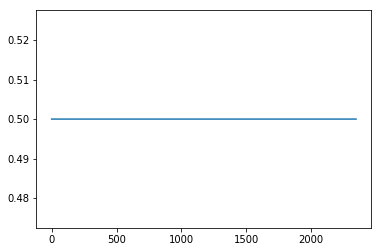

In [37]:
runner.recorder.plot_lr() 
''' this name of the recorder object is registered by Runner.__init__ and 
handled by name property of the Callback base class '''

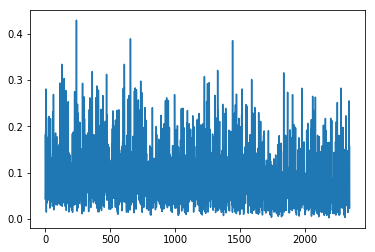

In [38]:
runner.recorder.plot_loss()

# Parameter scheduler callback
- variable learning rate
- applicable to all other hyperparameters

In [39]:
#export
class ParamScheduler(Callback):
    # simply reset desired parameter in param_groups using sched_func
    _order = 1 # start later than TrainEvalCallback etc
    def __init__(self, pname, sched_func):
        self.pname = pname
        self.sched_func = sched_func
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.epochs_elp/self.epochs) # percent epoch elapsed
    def begin_batch(self):
        if self.in_train:
            self.set_param()

### scheduler function
- we want a function that at initialization we can specify start and end values of the parameter, but once called only take one pos (percent) argument and returns the current position according to the schedule function

In [40]:
def lin_sched(start, end):
    # pos argument is the percent from start to end
    def _inner(start,end, pos): return start+pos*(end-start)
    return partial(_inner, start, end)

f = lin_sched(0,5)
f(0.5)

2.5

Annealer essentially hides some parameters from the function in both initialization and call phase

In [41]:
def annealer(f):
    def _inner(start, end): return partial(f,start,end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start+pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_exp(start, end, pos): return start*(end/start)**pos
@annealer
def sched_no(start, end, pos): return start

In [42]:
f = sched_lin(0, 5)
f(0.5)

2.5

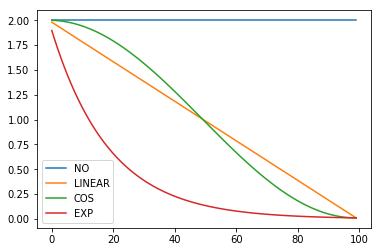

In [43]:
# just plotting
#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape)) # Tensor doesn't have ndim attribute so we dynamically create one
# this only works for python, which is a dynamic language

annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

### combine schedule functions
- allows what schedule function to use and how many percent to use

In [44]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1
    pcts = torch.tensor([0]+listify(pcts))
    assert torch.all(pcts>=0)
    pcts = torch.cumsum(pcts, 0) # pcts is cumsum now
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max() #find out which scheds should currently be used
        actual_pos = (pos - pcts[idx])/(pcts[idx+1]-pcts[idx]) # percent pos wrt current schedule
        return scheds[idx](actual_pos)
    return _inner

30% budget to go from 0.3 to 0.6 following cosine, and then 70% time to go from 0.6 to 0.2 fllowing another cosine

In [45]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3,0.6), sched_cos(0.6,0.2)])

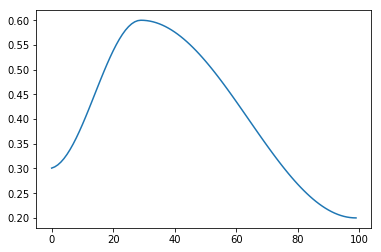

In [46]:
a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)
plt.plot(a, [sched(o) for o in p])

# Combining all callbacks
- TrainEval, Recorder, AvgStats and ParamScheduler

In [48]:
cb_funcs = [Recorder, 
           partial(AvgStatsCallback, accuracy),
           partial(ParamScheduler, 'lr', sched)]

In [47]:
learn = Learner(*get_model(data), loss_func, data)

In [49]:
runner = Runner(cb_funcs= cb_funcs)
runner.fit(5,learn)

train: ['loss = 0.357826328125', 'accuracy = tensor(0.8917)']
valid: ['loss = 0.167788818359375', 'accuracy = tensor(0.9523)']
train: ['loss = 0.16764318359375', 'accuracy = tensor(0.9495)']
valid: ['loss = 0.2017992919921875', 'accuracy = tensor(0.9418)']
train: ['loss = 0.114507275390625', 'accuracy = tensor(0.9646)']
valid: ['loss = 0.1122421875', 'accuracy = tensor(0.9669)']
train: ['loss = 0.0797396923828125', 'accuracy = tensor(0.9752)']
valid: ['loss = 0.10411583251953126', 'accuracy = tensor(0.9707)']
train: ['loss = 0.0596636767578125', 'accuracy = tensor(0.9813)']
valid: ['loss = 0.09167529296875', 'accuracy = tensor(0.9735)']


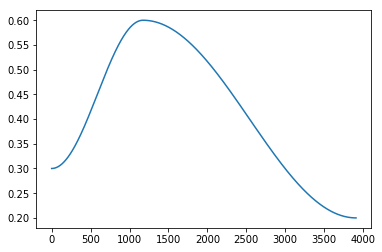

In [50]:
runner.recorder.plot_lr()

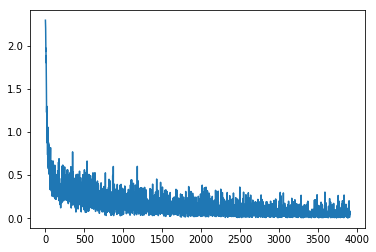

In [51]:
runner.recorder.plot_loss()

# Export

In [52]:
!./notebook2script.py Callbacks_databunch_Lesson3.ipynb

Converted Callbacks_databunch_Lesson3.ipynb to exp/nb_Callbacks.py
